### Modelo2_LSTM

### LSTM 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping

df = pd.read_csv('../dataset/data/sample_4M_cod.csv', dtype='int64')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 42 columns):
 #   Column                       Dtype
---  ------                       -----
 0   L4_SRC_PORT                  int64
 1   L4_DST_PORT                  int64
 2   PROTOCOL                     int64
 3   L7_PROTO                     int64
 4   IN_BYTES                     int64
 5   IN_PKTS                      int64
 6   OUT_BYTES                    int64
 7   OUT_PKTS                     int64
 8   TCP_FLAGS                    int64
 9   CLIENT_TCP_FLAGS             int64
 10  SERVER_TCP_FLAGS             int64
 11  FLOW_DURATION_MILLISECONDS   int64
 12  DURATION_IN                  int64
 13  DURATION_OUT                 int64
 14  MIN_TTL                      int64
 15  MAX_TTL                      int64
 16  LONGEST_FLOW_PKT             int64
 17  SHORTEST_FLOW_PKT            int64
 18  MIN_IP_PKT_LEN               int64
 19  MAX_IP_PKT_LEN               int64
 20  SR

In [3]:
y = df.AttackCod

NIDS_features=['MAX_IP_PKT_LEN','LONGEST_FLOW_PKT','SRC_TO_DST_SECOND_BYTES','IN_BYTES',
                'SRC_TO_DST_AVG_THROUGHPUT','MIN_TTL','MAX_TTL','L7_PROTO','FLOW_DURATION_MILLISECONDS',
                'DURATION_IN','L4_DST_PORT','SHORTEST_FLOW_PKT','DST_TO_SRC_SECOND_BYTES','OUT_BYTES',
                'IN_PKTS','DST_TO_SRC_AVG_THROUGHPUT','OUT_PKTS','MIN_IP_PKT_LEN','TCP_WIN_MAX_IN',
                'NUM_PKTS_UP_TO_128_BYTES','TCP_FLAGS','CLIENT_TCP_FLAGS']

X = df[NIDS_features]

# Escalamos solo las características (X) y no las etiquetas (y)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [4]:
# Dividir datos
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(X_train.shape,X_test.shape)

(2800000, 22) (600000, 22)


In [5]:
model = keras.Sequential([
    # Primera capa LSTM con 24 neuronas, retornando secuencias para alimentar la siguiente capa LSTM
    layers.LSTM(24, return_sequences=True, input_shape=(X_train.shape[1], 1), dropout=0.1), 
    # Segunda capa LSTM con 12 neuronas, esta vez no retorna secuencias ya que es la última capa LSTM    
    layers.LSTM(12, dropout=0.1),
    # Capa de salida con 2 neuronas para la clasificación o predicción
    layers.Dense(1, activation='sigmoid')
])

# Configurar el optimizador Adam con momentum
momentum = 0.9  # se puede ajustar
opt = Adam(learning_rate=0.01, beta_1=momentum)

# Configurar el optimizador Adam
model.compile(optimizer=opt, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Visualizar el modelo en forma de gráfico y guardarlo en un archivo
plot_model(model, to_file='modelLSTM_mi22.png', show_shapes=True, show_layer_names=True)

# Resumen del modelo
model.summary()

# Definir el callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

start_time = time.time()
# Entrenar modelo
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=160, callbacks=[early_stopping])

# Calcular el tiempo transcurrido en minutos
end_time = time.time()
elapsed_time_minutes = (end_time - start_time) / 60
print("Tiempo de entrenamiento (minutos):", elapsed_time_minutes)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 22, 24)            2496      
                                                                 
 lstm_1 (LSTM)               (None, 12)                1776      
                                                                 
 dense (Dense)               (None, 1)                 13        
                                                                 
Total params: 4,285
Trainable params: 4,285
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
17500/17500 [==============================] - 143s 8ms/step - loss: 0.0623 - accuracy: 0.9800 - val_loss: 0.0512 - val_accuracy: 0.9841
Epoch 2/15
17500/17500 [==============================] - 139s 8ms/step - loss: 0.0405 - accuracy: 0.9875 - val_loss: 0.0210 - val_accuracy: 0.9939
Epoch 3/15
17500/17500

### Metricas

In [6]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Realiza predicciones en los datos de prueba
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convierte las probabilidades en clases predichas (usando un umbral de 0.5)

# Calcula la precisión, el recall y el F1-score para la clasificación binaria
precision = precision_score(y_test, y_pred_classes, average='binary')
recall = recall_score(y_test, y_pred_classes, average='binary')
f1 = f1_score(y_test, y_pred_classes, average='binary')
accuracy = accuracy_score(y_test, y_pred_classes)


print("Exactitud:", accuracy)
print("Sensibilidad:", recall)
print("Precisión:", precision)
print("F1-score:", f1)

18750/18750 [==============================] - 56s 3ms/step
Exactitud: 0.9954483333333334
Sensibilidad: 0.9952481626228808
Precisión: 0.9956432538822078
F1-score: 0.9954456690497274


### Guardar modelo keras

In [7]:
model.save('models_keras/lstm_mi22.keras')

In [8]:
import pickle
# Guardar el historial de entrenamiento en un archivo(diccionario)
with open('models_keras/historylt_mi22.pkl', 'wb') as file:
    pickle.dump(history.history, file, protocol=pickle.HIGHEST_PROTOCOL)

##### cargar

In [ ]:
from keras.models import load_model
# Cargar el modelo desde un archivo en formato nativo de Keras
model = load_model('models_keras/lstm_.keras')

In [ ]:
import pickle
# Guardar el historial de entrenamiento en un archivo(diccionario)
with open('models_keras/historylt_.pkl', 'wb') as file:
    pickle.dump(history.history, file, protocol=pickle.HIGHEST_PROTOCOL)

### AUC

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calcular el AUC
auc = roc_auc_score(y_test, y_pred)

El Area bajo la curva(AUC) es: 0.9998451039935081


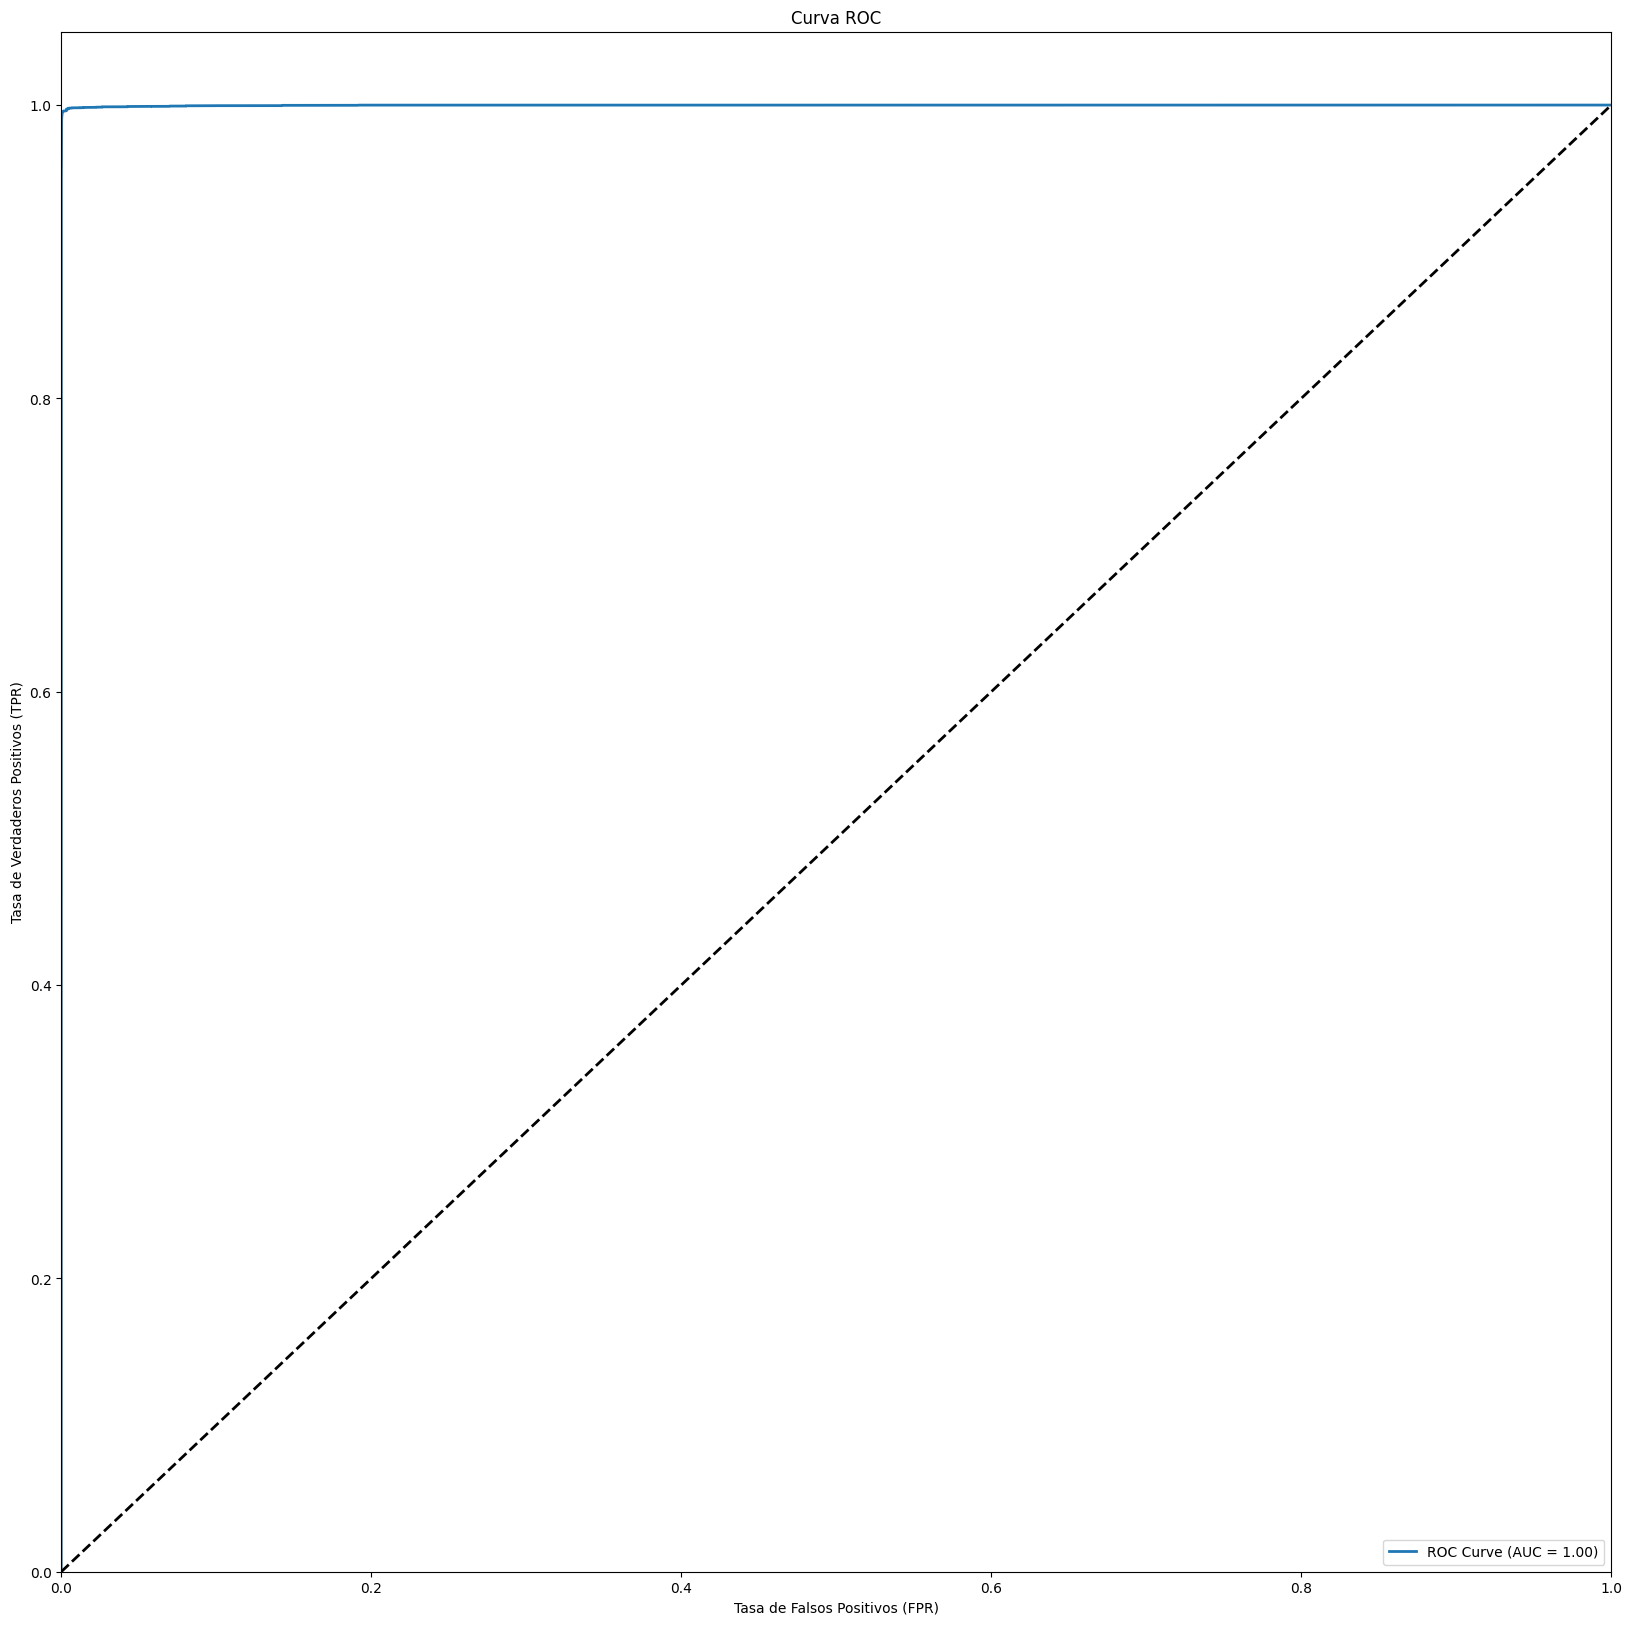

In [23]:
# Gráfica de la curva ROC
plt.figure(figsize=(15,15))
plt.plot(fpr, tpr, linewidth=4, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")

#auc_crv = auc(fpr, tpr)
print(f"El Area bajo la curva(AUC) es: {auc}")
# Mostrar la gráfica de la curva ROC
plt.show()

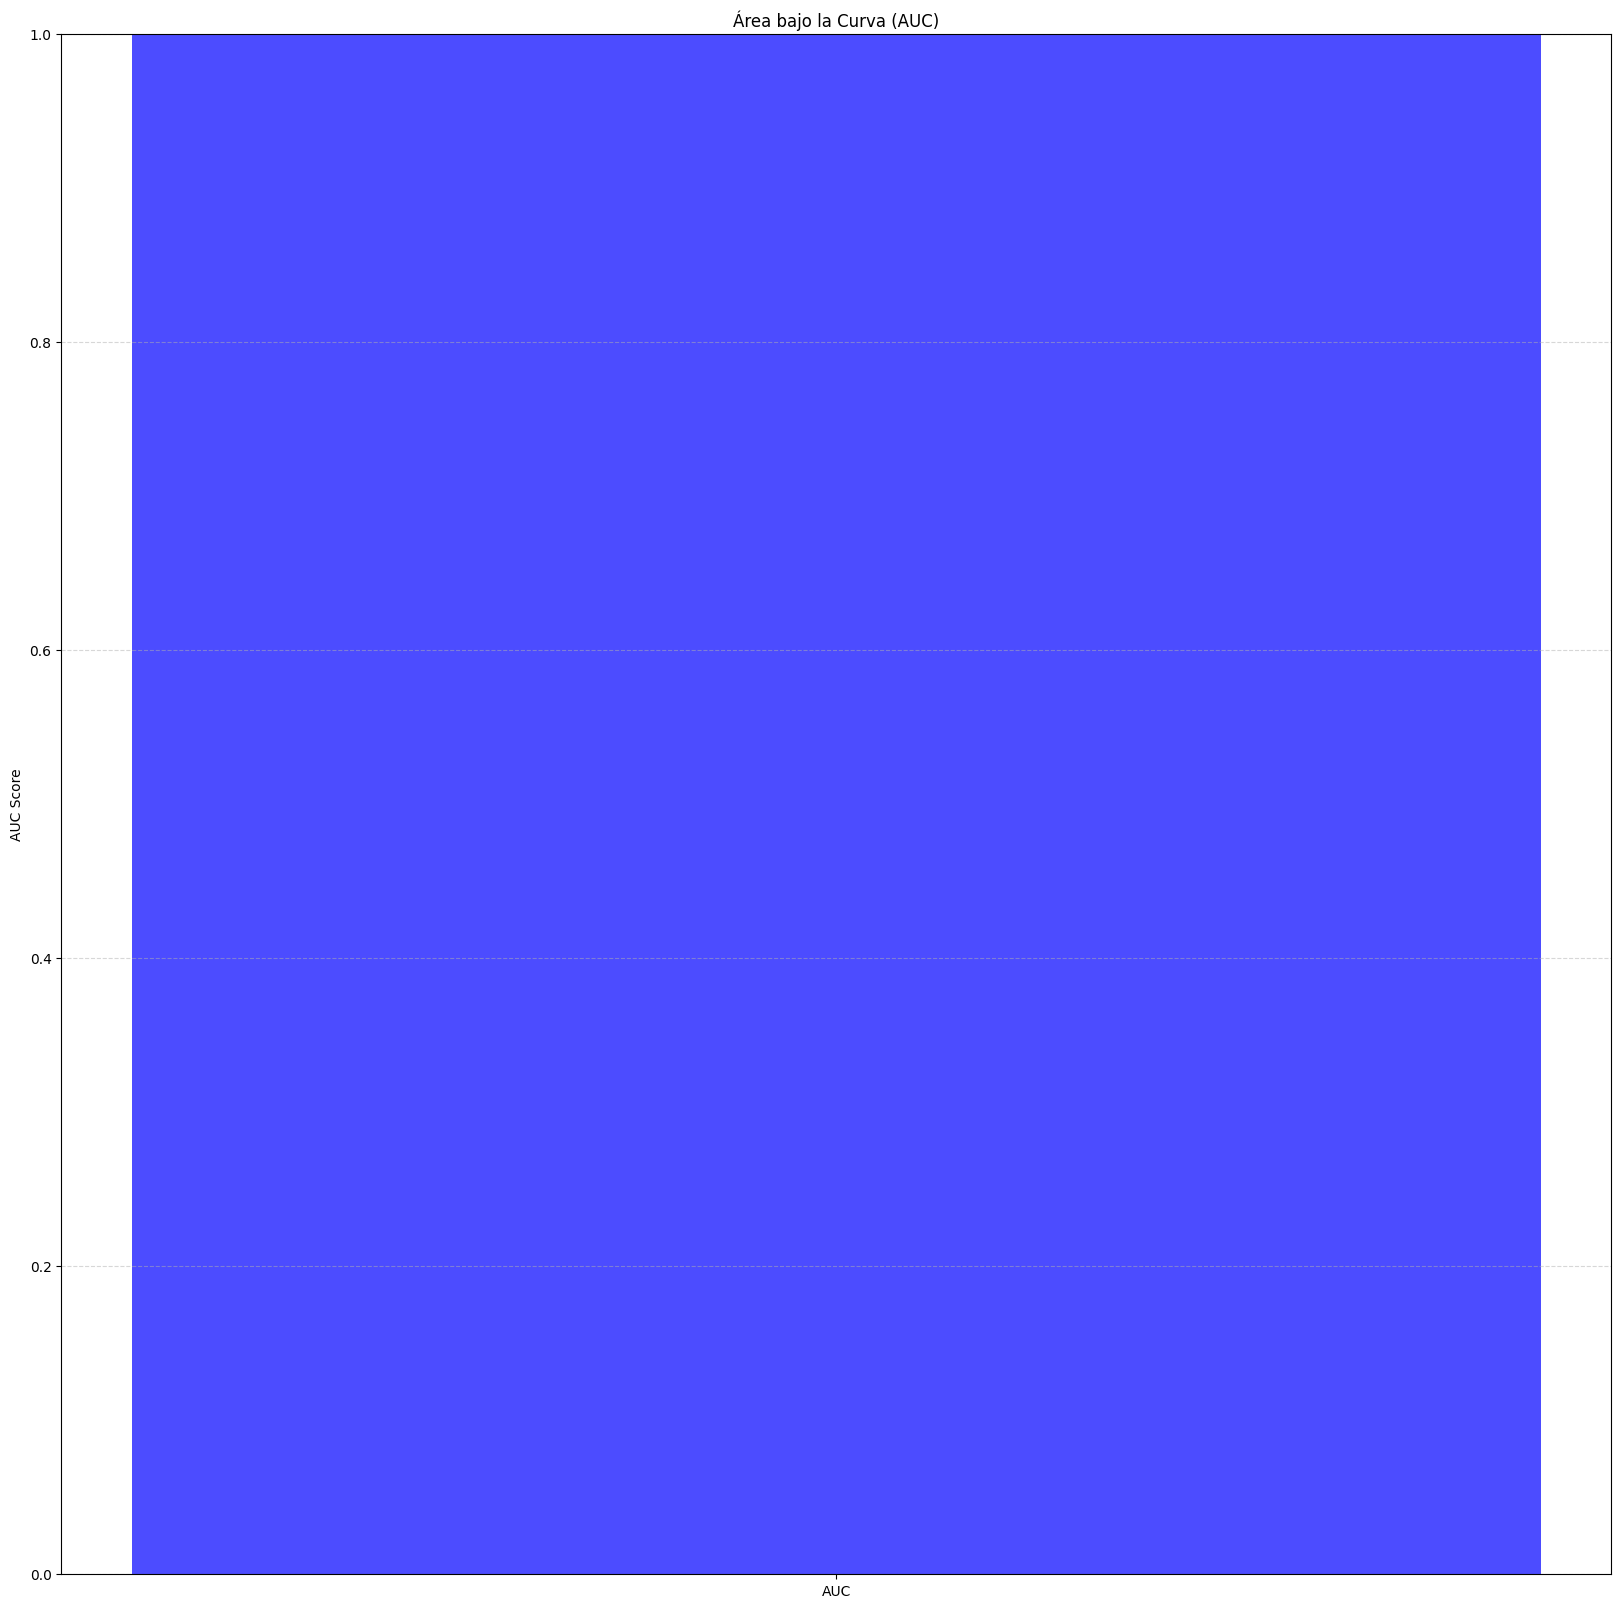

In [24]:
# Gráfica del AUC
plt.figure(figsize=(15,15))
plt.bar(['AUC'], [auc], color='b', alpha=0.7)
plt.ylim([0.0, 1.0])
plt.ylabel('AUC Score')
plt.title('Área bajo la Curva (AUC)')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Mostrar la gráfica del AUC
plt.show()

### Mejor

In [7]:
# Evaluar el modelo en los conjuntos de datos
train_metrics = model.evaluate(X_train, y_train, verbose=0)
val_metrics = model.evaluate(X_val, y_val, verbose=0)
test_metrics = model.evaluate(X_test, y_test, verbose=0)

# Imprimir las métricas
metric_names = ['loss', 'accuracy', 'recall', 'precision', 'f1']
print("Metricas Datos Entrenamiento:")
for name, val in zip(metric_names, train_metrics):
    print(f"{name}: {val}")

print("\nMetricas Datos Validación:")
for name, val in zip(metric_names, val_metrics):
    print(f"{name}: {val}")

print("\nMetricas datos de prueba:")
for name, val in zip(metric_names, test_metrics):
    print(f"{name}: {val}")

Metricas Datos Entrenamiento:
loss: 0.017748918384313583
accuracy: 0.9956203699111938

Metricas Datos Validación:
loss: 0.01718335598707199
accuracy: 0.9957366585731506

Metricas datos de prueba:
loss: 0.01848256215453148
accuracy: 0.9954266548156738


### Graficar Curvas Aprendizaje Modelo en memoria (no cargado)

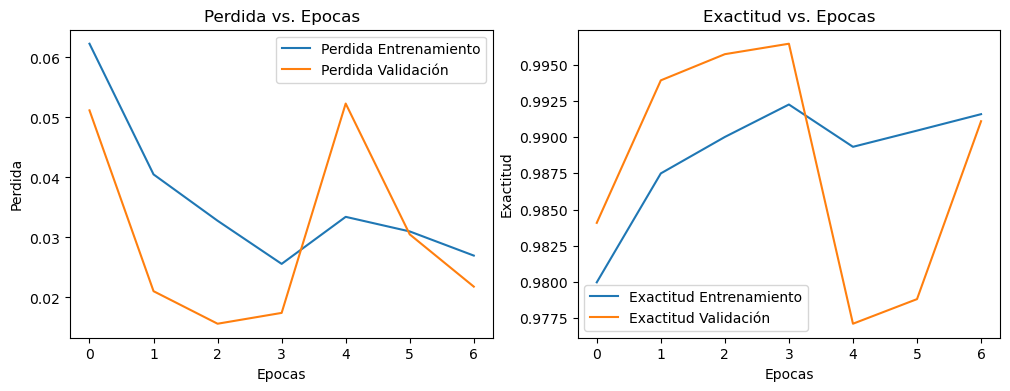

In [10]:
# Gráfico de la pérdida y la precisión en el entrenamiento y la validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Perdida Validación')
plt.title('Perdida vs. Epocas')
plt.xlabel('Epocas')
plt.ylabel('Perdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Exactitud Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Exactitud Validación')
plt.title('Exactitud vs. Epocas')
plt.xlabel('Epocas')
plt.ylabel('Exactitud')
plt.legend()

plt.show()

### Cargar diccionario de historia con pickle y graficar curvas de aprendizaje

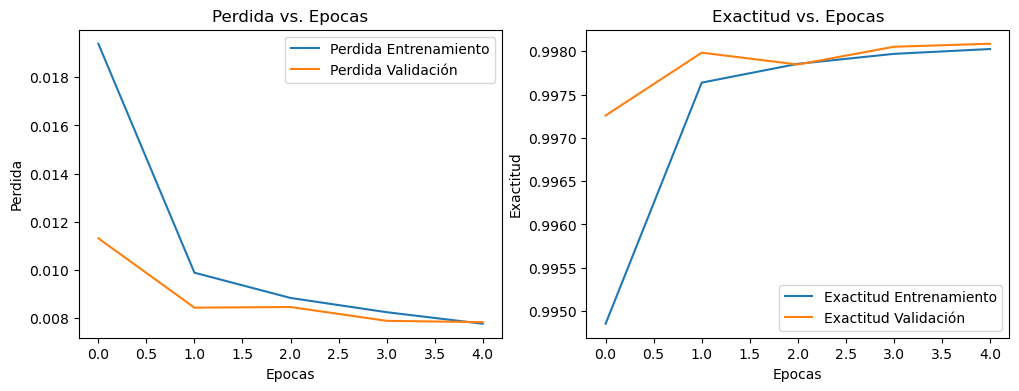

In [16]:

# Gráfico de la pérdida y la precisión en el entrenamiento y la validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Perdida Entrenamiento')
plt.plot(history['val_loss'], label='Perdida Validación')
plt.title('Perdida vs. Epocas')
plt.xlabel('Epocas')
plt.ylabel('Perdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Exactitud Entrenamiento')
plt.plot(history['val_accuracy'], label='Exactitud Validación')
plt.title('Exactitud vs. Epocas')
plt.xlabel('Epocas')
plt.ylabel('Exactitud')
plt.legend()

plt.show()


### Matriz de confusión

In [11]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Hacer predicciones
predicciones = model.predict(X_test)  # X_val es el conjunto de validación/prueba

# En un problema de clasificación binaria, normalmente se redondea la probabilidad a 0 o 1
# Esto es asumiendo que el modelo produce una salida de probabilidad para la clase positiva
predicciones_etiquetas = (predicciones > 0.5).astype(int)

# Generar la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones_etiquetas)

# Imprimir la matriz de confusión
print(matriz_confusion)

18750/18750 [==============================] - 63s 3ms/step
[[298810   1306]
 [  1425 298459]]


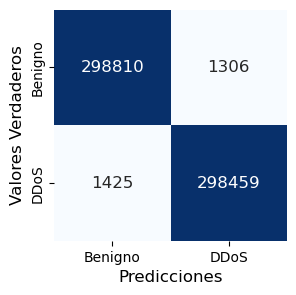

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que 'matriz_confusion' es tu matriz de confusión calculada previamente

# Definir los nombres de las clases
class_names = ["Benigno", "DDoS"]

# Crear un mapa de calor con Seaborn
plt.figure(figsize=(3, 3))  # Ajustar el tamaño del gráfico
sns.heatmap(matriz_confusion, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 12})  # Ajustar el tamaño de la fuente

# Añadir etiquetas y título para mayor claridad
plt.xlabel('Predicciones', fontsize=12)  # Ajustar el tamaño de la fuente
plt.ylabel('Valores Verdaderos', fontsize=12)  # Ajustar el tamaño de la fuente
#plt.title('Matriz de Confusión', fontsize=12)  # Ajustar el tamaño de la fuente
plt.show()
